In [2]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.patches import Ellipse

from abc import ABC, abstractmethod

In [3]:
class Neuron:
    def __init__(self, mean, cov, coord):
        self.mean_ = mean
        self.cov_ = cov
        self.coord_ = coord

In [4]:
class Lattice(ABC):
    def __init__(self, size):
        self.size_ = size
        self.neurons_ = None
        self.neurons_nb_ = None

        self.generate()

    @abstractmethod
    def generate(self):
        pass


class RectangularLattice(Lattice):
    def generate(self):
        self.neurons_ = []
        self.neurons_nb_ = self.size_[0] * self.size_[1]

        for i in range(0, self.size_[0]):
            for j in range(0, self.size_[1]):
                self.neurons_.append(Neuron(None, None, np.array([i, j])))


In [23]:
class SOCEM:
    def __init__(self, lattice: Lattice, learning_rate, random_state=None):
        self.learning_rate_ = learning_rate
        self.sigma_ = None
        self.lattice_ = lattice
        self.random_state = random_state

    def fit(self, X: np.ndarray, epochs):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        neurons_nb = self.lattice_.neurons_nb_
        neurons = self.lattice_.neurons_


        for i in range(0, neurons_nb):
            neurons[i].mean_ = self.initialize_mean(X)
            neurons[i].cov_ = self.initialize_cov(X)
            print(neurons[i].cov_)

        for ep in range(epochs):
            self.sigma_ = 1/(np.sqrt(ep + 1) * self.learning_rate_)
            print("Epoch:", ep)
            print("sigma^2:", self.sigma_**2)
            print("Weights, Covariance:")
            for neuron in self.lattice_.neurons_:
                print(neuron.mean_, end=' ')
                print()
                print(neuron.cov_)
                print()
            print("-----------------")
            
            clusters = [[] for _ in range(neurons_nb)]
            for x in X:
                # Find responsibilities for each x
                # E step
                responsibilities = self.find_responsibilities(x)
                
                # Define cluster for x based on largest posterior probability
                # C step
                k = np.argmax(responsibilities)
                clusters[k].append(x)

            #############

            # Update nodes
            ### M-step ###
            self.update_nodes(clusters)

    def neighbourhood_func(self, r, s):
        # r - fixed neuron index
        # s - arbitrary neuron index

        alpha = 0.5 / self.sigma_**2
        return np.exp(-alpha * self.distance(self.lattice_.neurons_[r].coord_, self.lattice_.neurons_[s].coord_))
    
    def likelihood(self, x, neuron_idx):
        neuron = self.lattice_.neurons_[neuron_idx]
        d = x.shape[0]
        return np.exp(-0.5*((x - neuron.mean_).T @ np.linalg.inv(neuron.cov_) @ (x - neuron.mean_))) / ((2*np.pi)**(d/2) * np.linalg.det(neuron.cov_)**0.5)

    
    def find_responsibilities(self, x):
        # returns responsibilities corresponding to x
        responsibilities = np.zeros(self.lattice_.neurons_nb_)
        
        for k in range(self.lattice_.neurons_nb_):
            enumerator = 0
            denominator = 0

            for l in range(self.lattice_.neurons_nb_):
                enumerator += self.neighbourhood_func(k, l) * np.log(self.likelihood(x, l))
            
            for j in range(self.lattice_.neurons_nb_):
                val = 0
                for l in range(self.lattice_.neurons_nb_):
                    val += self.neighbourhood_func(j, l) * np.log(self.likelihood(x, l))

                denominator += np.exp(val)

            responsibilities[k] = np.exp(enumerator) / denominator

        return responsibilities


    @staticmethod
    def distance(v1: np.ndarray, v2: np.ndarray):
        # Calculating euclidian distance
        return np.sqrt(np.sum((v1 - v2) ** 2))

    def update_nodes(self, clusters):
        # Updating all neuron based on batch mode

        for neuron_idx in range(self.lattice_.neurons_nb_):
            numerator_mean = 0
            numerator_cov = 0
            denominator = 0
            
            for k in range(self.lattice_.neurons_nb_):
                val = self.neighbourhood_func(k, neuron_idx)
                for x in clusters[k]:
                    numerator_mean += val * x
                
                denominator += val * len(clusters[k])
            
            self.lattice_.neurons_[neuron_idx].mean_ = numerator_mean / denominator
            mean = self.lattice_.neurons_[neuron_idx].mean_

            for k in range(self.lattice_.neurons_nb_):
                val = self.neighbourhood_func(k, neuron_idx)
                for x in clusters[k]:
                    numerator_cov += val * np.outer(x - mean, x - mean)
            
            self.lattice_.neurons_[neuron_idx].cov_ = numerator_cov / denominator

        
    def predict(self, X):
        probabilities = np.zeros((X.shape[0], self.lattice_.neurons_nb_))

        for i in range(X.shape[0]):
            # Find best matching unit for x_n
            winner_idx = self.find_bmu(X[i])
            for neuron_idx in range(self.lattice_.neurons_nb_):
                probabilities[i, neuron_idx] = self.neighbourhood_func(winner_idx, neuron_idx)
        
        return np.argmax(probabilities, axis=1)

            
    @staticmethod
    def initialize_mean(X):
        mean = np.zeros(X.shape[1])
        for i in range(0, X.shape[1]):
            mean[i] = np.random.uniform(np.min(X[:, i]), np.max(X[:, i]))

        return mean

    @staticmethod
    def initialize_cov(X):
        cov_matrix = np.zeros((X.shape[1], X.shape[1]))
        for i in range(0, X.shape[1]):
            cov_matrix[i, i] = np.random.uniform(0, (np.max(X[:, i]) - np.min(X[:, i]))/6)**2
            
        return cov_matrix

### Example 1

Text(0.5, 1.0, '1D Gaussian Mixture Dataset')

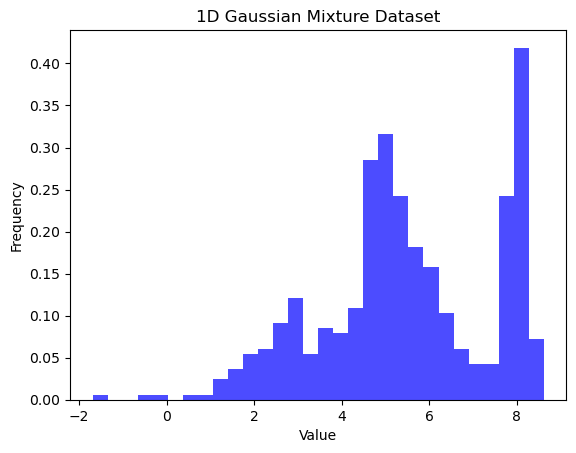

In [24]:
# Define the parameters for the Gaussian mixture
means = np.array([3, 5, 6, 8])
variances = np.array([1.2, 0.4, 0.9, 0.2])
n_samples = 120

# Generate data points from the Gaussian mixture
data = np.concatenate([np.random.normal(means[i], variances[i], n_samples) for i in range(len(means))])

# Visualize the generated data
hist_data, bin_edges, _ = plt.hist(data, bins=30, density=True, alpha=0.7, color='b')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('1D Gaussian Mixture Dataset')

In [71]:
data

array([ 2.03162175,  6.44618327,  2.2826125 ,  3.56694839,  4.31514734,
        1.54179744,  4.61082765,  2.85342025,  4.21501857,  1.90335702,
        1.76456375,  4.45175574,  3.60224676,  3.16661541,  3.76891334,
        3.6327992 ,  1.61476772,  0.34399982,  0.98189219,  0.8542869 ,
        0.33775807,  2.22308306,  2.36591482,  2.95294899,  3.25797114,
        2.53876944,  2.69531511,  3.08790249,  1.8033554 ,  2.14337245,
        3.04249962,  2.18646556,  2.31374273,  2.87296522,  4.60299761,
        3.38239835,  2.5948857 ,  2.29767807,  2.86209607,  5.69018135,
       -0.77689983,  3.64216307,  3.27898853,  4.04113434,  1.62214474,
        5.53721309,  4.20113131,  2.93830201,  3.19174524,  2.1404837 ,
        3.06062739,  2.8279951 ,  4.13229047,  3.42917307,  2.89986096,
        3.81336732,  3.66727245,  3.26726335,  1.16521742,  4.23505341,
        1.60048949,  1.78852602,  2.87367841,  3.61442659,  4.68927332,
        0.9747644 ,  4.76548079,  4.96375549,  2.44632608,  2.75

In [72]:
X = data.reshape(-1, 1)
X

array([[ 2.03162175],
       [ 6.44618327],
       [ 2.2826125 ],
       [ 3.56694839],
       [ 4.31514734],
       [ 1.54179744],
       [ 4.61082765],
       [ 2.85342025],
       [ 4.21501857],
       [ 1.90335702],
       [ 1.76456375],
       [ 4.45175574],
       [ 3.60224676],
       [ 3.16661541],
       [ 3.76891334],
       [ 3.6327992 ],
       [ 1.61476772],
       [ 0.34399982],
       [ 0.98189219],
       [ 0.8542869 ],
       [ 0.33775807],
       [ 2.22308306],
       [ 2.36591482],
       [ 2.95294899],
       [ 3.25797114],
       [ 2.53876944],
       [ 2.69531511],
       [ 3.08790249],
       [ 1.8033554 ],
       [ 2.14337245],
       [ 3.04249962],
       [ 2.18646556],
       [ 2.31374273],
       [ 2.87296522],
       [ 4.60299761],
       [ 3.38239835],
       [ 2.5948857 ],
       [ 2.29767807],
       [ 2.86209607],
       [ 5.69018135],
       [-0.77689983],
       [ 3.64216307],
       [ 3.27898853],
       [ 4.04113434],
       [ 1.62214474],
       [ 5

In [38]:
lattice = RectangularLattice((2, 2))
som = SOCEM(lattice, 1.005, 42)

In [39]:
som.fit(X, 100)

[[1.92643006]]
[[0.76385596]]
[[0.0518647]]
[[1.59906319]]
Epoch: 0
sigma^2: 0.990074503106359
Weights, Covariance:
[3.13707892] [6.26818506] [1.22294652] [0.36508755] 
Epoch: 1
sigma^2: 0.4950372515531794
Weights, Covariance:
[5.34830096] [5.6968555] [5.25084849] [5.52779238] 
Epoch: 2
sigma^2: 0.33002483436878627
Weights, Covariance:
[5.39743841] [6.1306081] [4.31914512] [5.51174387] 
Epoch: 3
sigma^2: 0.24751862577658976
Weights, Covariance:
[5.26309709] [6.51618317] [3.82268643] [5.54032685] 
Epoch: 4
sigma^2: 0.19801490062127178
Weights, Covariance:
[5.19484497] [7.01117015] [3.46950242] [5.5896967] 
Epoch: 5
sigma^2: 0.1650124171843932
Weights, Covariance:
[5.20986351] [7.3189664] [3.16013016] [5.61349615] 
Epoch: 6
sigma^2: 0.14143921472947985
Weights, Covariance:
[5.21330149] [7.47463749] [2.96005573] [5.62618297] 
Epoch: 7
sigma^2: 0.12375931288829485
Weights, Covariance:
[5.21513109] [7.56707021] [2.83728137] [5.6367219] 
Epoch: 8
sigma^2: 0.11000827812292878
Weights, Covaria

In [40]:
for neuron in som.lattice_.neurons_:
    print(neuron.mean_, neuron.cov_)

[5.01912377] [[0.10197467]]
[7.9810613] [[0.05267298]]
[2.72485852] [[0.9348572]]
[6.29786323] [[0.2009591]]


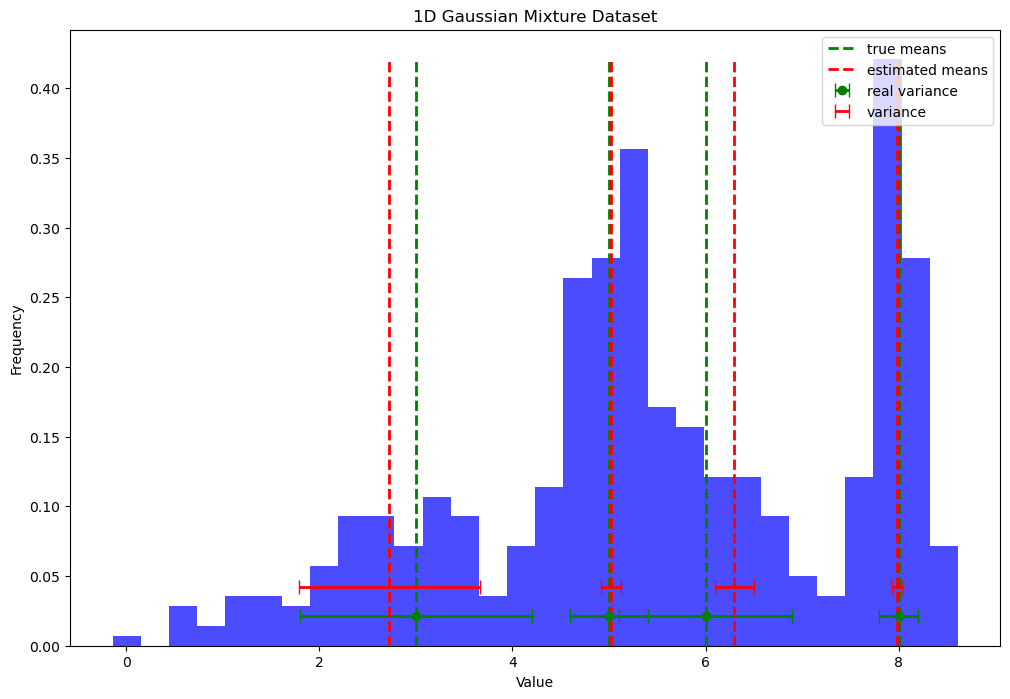

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))

# Visualize the generated data
ax.hist(data, bins=30, density=True, alpha=0.7, color='b')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('1D Gaussian Mixture Dataset')

neuron_variances = np.array([neuron.cov_[0] for neuron in som.lattice_.neurons_]).flatten()
neuron_weights = np.array([neuron.mean_ for neuron in som.lattice_.neurons_]).flatten()

# Plot vertical lines for real means:
ax.vlines(x=means, color='g', linestyle='--', linewidth=2, label='true means', ymin=0, ymax=max(hist_data))
ax.errorbar(means, np.full(len(means), max(hist_data) * 0.05), xerr=variances, fmt='go', elinewidth=2, capsize=5, label='real variance')

# Plot vertical lines for neuron weights
ax.vlines(x=neuron_weights, color='r', linestyle='--', linewidth=2, label='estimated means', ymin=0, ymax=max(hist_data))
ax.errorbar(x=neuron_weights, y=np.full(len(neuron_weights), max(hist_data) * 0.1), xerr=neuron_variances, color='r', fmt='none', elinewidth=2, capsize=5, label='variance')


ax.legend(loc='upper right');

### Example 4

In [26]:
def generate_dependent_mixture(means1, variances1, means2, variances2, probabilities_matrix, n_samples):
    probabilities = probabilities_matrix.flatten()
    sample_index = np.random.choice(a=probabilities.size, p=probabilities, size=n_samples)
    adjusted_index = np.unravel_index(sample_index, probabilities_matrix.shape)
    mixture_indexes = np.vstack(adjusted_index)
    
    labels = []
    data = []
    for label, idx in zip(sample_index, mixture_indexes.T):
        mix1_idx = idx[0]
        mix2_idx = idx[1]

        mix1_val = np.random.normal(means1[mix1_idx], variances1[mix1_idx]**0.5)
        mix2_val = np.random.normal(means2[mix2_idx], variances2[mix2_idx]**0.5)
        
        data.append([mix1_val, mix2_val])
        labels.append(label)

    return np.array(data), np.array(labels)

In [56]:
n_samples = 500

# Define the parameters for the 2D Gaussian mixture
means1 = np.array([0, 5])
variances1 = np.array([1, 0.8])

means2 = np.array([-5, -1.5])
variances2 = np.array([1.2, 0.7])

probabilities = np.array([[0.15, 0.05],
                          [0.4, 0.4]])

In [57]:
data, labels = generate_dependent_mixture(means1, variances1, means2, variances2, probabilities, n_samples)

In [58]:
mean_x = np.mean(data[:, 0])
mean_y = np.mean(data[:, 1])

# Center the data by subtracting the means
centered_data = data - np.array([mean_x, mean_y])

# Calculate the covariance matrix
cov_matrix = np.cov(centered_data, rowvar=False)

# The covariance between x and y is given by cov_matrix[0, 1]
# The variances of x and y are given by cov_matrix[0, 0] and cov_matrix[1, 1] respectively

print("Covariance between x and y:", cov_matrix[0, 1])
print("Variance of x:", cov_matrix[0, 0])
print("Variance of y:", cov_matrix[1, 1])

Covariance between x and y: 1.0019123277246673
Variance of x: 5.419700117439719
Variance of y: 4.016178826708237


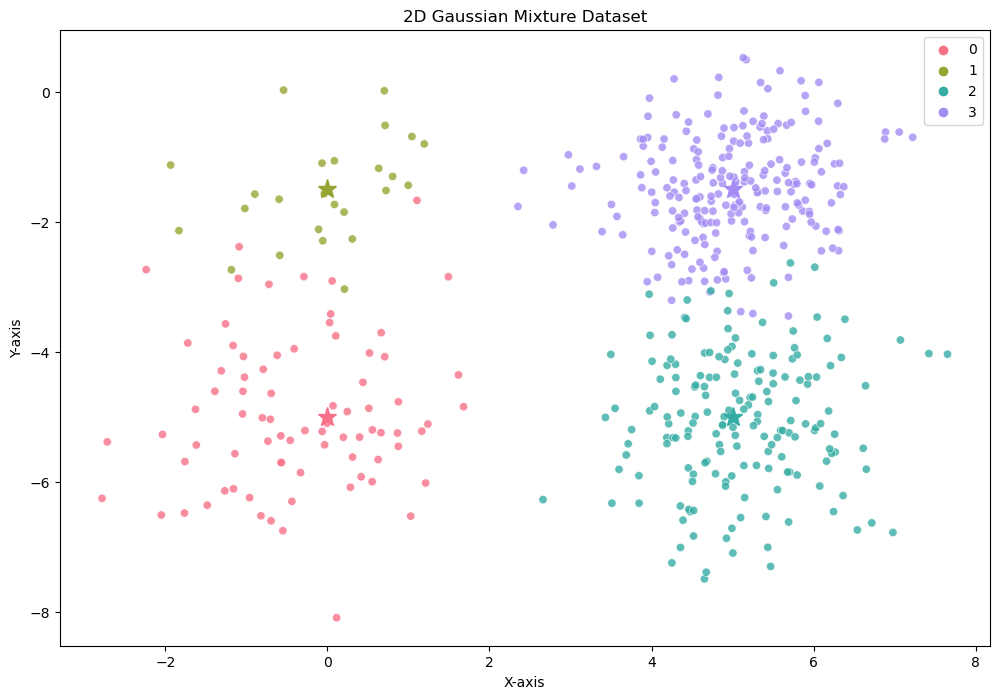

In [59]:
fig, ax = plt.subplots(figsize=(12, 8))

# Generate data points from the 2D Gaussian mixture

custom_palette = sns.color_palette("husl", len(np.unique(labels)))  # Use Seaborn's "husl" palette for n colors

# Visualize the generated data
sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=labels, ax=ax, palette=custom_palette)

covariances = np.array([(x, y) for x in variances1 for y in variances2])
means = np.array([(x, y) for x in means1 for y in means2])
for mean, color in zip(means, custom_palette):
    ax.plot(mean[0], mean[1], color=color, markersize=14, marker='*')


ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset');

In [64]:
lattice = RectangularLattice((2, 2))
som = SOCEM(lattice, 1.002, random_state=41)

In [65]:
som.fit(data, 100)

[[1.38548271 0.        ]
 [0.         0.00388864]]
[[0.11025821 0.        ]
 [0.         0.91971268]]
[[0.33389914 0.        ]
 [0.         0.1648561 ]]
[[0.70025182 0.        ]
 [0.         0.00994613]]
Epoch: 0
sigma^2: 0.9960119680798083
Weights, Covariance:
[-0.16316985 -7.68728176] 
[[1.38548271 0.        ]
 [0.         0.00388864]]

[-1.56663962 -2.88640271] 
[[0.11025821 0.        ]
 [0.         0.91971268]]

[ 6.79182756 -4.47948552] 
[[0.33389914 0.        ]
 [0.         0.1648561 ]]

[-0.83768467 -5.35458394] 
[[0.70025182 0.        ]
 [0.         0.00994613]]

-----------------


C:\Users\ostap\AppData\Local\Temp\ipykernel_16912\728580449.py:72: RuntimeWarning: divide by zero encountered in log
  enumerator += self.neighbourhood_func(k, l) * np.log(self.likelihood(x, l))
C:\Users\ostap\AppData\Local\Temp\ipykernel_16912\728580449.py:77: RuntimeWarning: divide by zero encountered in log
  val += self.neighbourhood_func(j, l) * np.log(self.likelihood(x, l))
C:\Users\ostap\AppData\Local\Temp\ipykernel_16912\728580449.py:81: RuntimeWarning: invalid value encountered in scalar divide
  responsibilities[k] = np.exp(enumerator) / denominator


Epoch: 1
sigma^2: 0.49800598403990404
Weights, Covariance:
[ 4.01221708 -2.99081138] 
[[5.08082922 0.87634085]
 [0.87634085 3.59882969]]

[ 3.88009925 -3.25341645] 
[[5.60099941 1.17365775]
 [1.17365775 3.99568798]]

[ 3.98473332 -3.35217966] 
[[5.27076373 0.80375911]
 [0.80375911 4.20410474]]

[ 3.80344217 -3.58807699] 
[[5.85007698 1.15767707]
 [1.15767707 4.23014549]]

-----------------
Epoch: 2
sigma^2: 0.3320039893599362
Weights, Covariance:
[ 4.4193588  -2.29954229] 
[[3.3422263  0.61285878]
 [0.61285878 2.73930074]]

[ 3.67365392 -3.16991351] 
[[6.04131782 0.97881553]
 [0.97881553 3.95934922]]

[ 4.23798948 -3.4946194 ] 
[[4.7678652  0.49514867]
 [0.49514867 3.5674545 ]]

[ 3.21400924 -4.35689578] 
[[7.25563308 0.65530199]
 [0.65530199 3.63052755]]

-----------------
Epoch: 3
sigma^2: 0.24900299201995207
Weights, Covariance:
[ 4.72875017 -2.00306497] 
[[2.01816308 0.53156173]
 [0.53156173 2.08853786]]

[ 3.34445201 -2.91454456] 
[[6.34144401 0.33030358]
 [0.33030358 4.06538904]]

In [66]:
neuron_means = np.array([neuron.mean_ for neuron in som.lattice_.neurons_])
neuron_variances = np.array([neuron.cov_ for neuron in som.lattice_.neurons_])

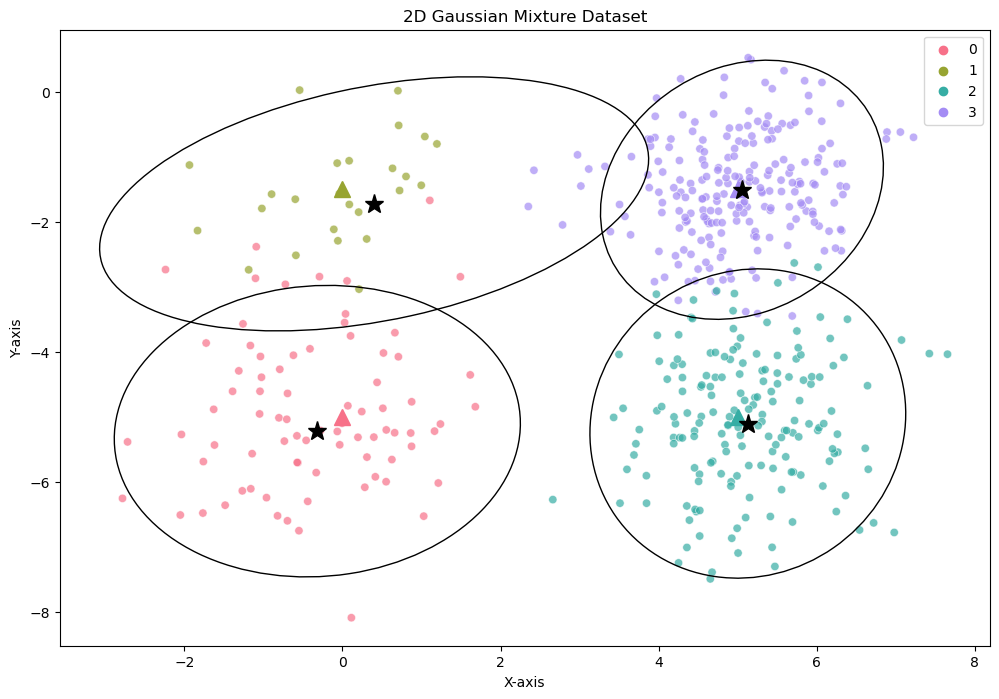

In [67]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.7, hue=labels, ax=ax, palette=custom_palette)


# Plot true parameters
for mean, color in zip(means, custom_palette):
    ax.plot(mean[0], mean[1], color=color, markersize=12, marker='^')


# Plot neuron parameters
for mean, cov in zip(neuron_means, neuron_variances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='black', fill=False)
    ax.add_patch(ell)
    ax.plot(mean[0], mean[1], color='black', markersize=14, marker='*')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset')
ax.legend(loc='best');